This is the code for experiments with the Dirichlet-multinomial model, using the whole database. Some of the code was meant to transform the data and store the result into csv files to be extracted when going back to the experiment later after closing the notebook.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tk
import scipy.stats as st
import matplotlib.colors as cl

from tqdm.notebook import tqdm

### Fix directories

data_dir = "../data/initial database/output" #path to project folder

os.chdir(data_dir) #Select the project directory

### Import the data from the csv files

def select_directory(sample, file_name = "compounds", part = 1):
    """Returns the file directory corresponding to the file_name.csv file in the folder corresponding to the given sample
    (DiAcids, Fallopia, Ruthenium or Ruthenium2).
    
    the input part indicates the subfolder in which it is stored (pt1 or pt2)."""
    return data_dir + "/" + sample + "/pt" + str(part) + "/" + file_name + ".csv"

def df_from_csv(directory):
    """Extracts the csv file of the file contained in the directory and stores it in a pandas dataframe."""
    with open(directory) as file:
        return pd.read_csv(file)

#Convert the data into pandas dataframes and compute intratios.

sample_names = ["DiAcids", "Fallopia", "Ruthenium", "Ruthenium2"]

data = pd.DataFrame({"compounds" : [df_from_csv(select_directory(sample)) for sample in sample_names],
                     "peaks" : [df_from_csv(select_directory(sample, file_name = "ms2_peaks")) for sample in sample_names],
                     "spectra" : [df_from_csv(select_directory(sample, file_name = "ms2_spectra")) for sample in sample_names]
                    }, index = sample_names)

def peaks_in_list(sample):
    """Returns a dataframe indexed by spectrum_id with entries lists of mz, list of
    intensities and sum of intensities of the ms2 peaks corresponding to this spectrum id."""
    
    groups = data["peaks"][sample].groupby(["spectrum_id"])
    df = groups.agg(list)
    
    return df.loc[:,["mz", "intensity"]]

list_format_sp = pd.Series([peaks_in_list(sample) for sample in sample_names], index = sample_names)

def get_spectrum(sample, spectrum_id):
    """Select a spectrum in the list_format_sp dataframe."""
    return pd.Series(list_format_sp[sample].intensity[spectrum_id], index = list_format_sp[sample].mz[spectrum_id])

def display(spectrum):
    x = spectrum.index
    plt.bar(x, spectrum, width = .5)
    plt.yscale("log")
    
def make_table(sample, spectrum_id):
    """Make a contingency table out of the two spectra sp1 and sp2. Only consider peaks that are in both spectra.
    
    Input should be in the following form
    
    sample : a couple of sample names ("Fallopia", "DiAcids", "Ruthenium" or "Ruthenium2") ;
    spectrum_id : a couple of spectrum_id of the corresponding sample.
    
    The output is a 2 * d contingency tables containing the intensities of the selected peaks, where d is the number of selected peaks in each spectrum.    
    """
    
    #Extract the spectra as table with two columns, mz and intensity.
    sp1 = pd.DataFrame({"mz" : list_format_sp[sample[0]]["mz"][spectrum_id[0]],
                        "intensity" : list_format_sp[sample[0]]["intensity"][spectrum_id[0]]
                       })
    
    sp2 = pd.DataFrame({"mz" : list_format_sp[sample[1]]["mz"][spectrum_id[1]],
                        "intensity" : list_format_sp[sample[1]]["intensity"][spectrum_id[1]]
                       })
    
    #Initialization of the rows of the output table.
    row1, row2 = [], []
    
    k1, k2 = len(sp1), len(sp2)
    
    #Indices running through the mz list.
    i, j = 0, 0
    while i < k1 and j < k2:
        
        mz1, mz2 = sp1.mz[i], sp2.mz[j]
        if abs(mz1 - mz2) < 1e-5 * (mz1 + mz2) / 2: #Machine precision is 10ppm.
            #if the peaks have similar mz, their intensities are stored in row1 and row2.
            row1.append(sp1.intensity[i])
            row2.append(sp2.intensity[j])
            i += 1
            j += 1
        
        #If the mz are distinct, the index corresponding to the smallest mz moves on to the next one (the mz are sorted in incresasing order in the sp_i.mz lists)
        elif sp1.mz[i] < sp2.mz[j]:
            i += 1
            
        else :
            j += 1
            
    return np.array([row1, row2])



In [2]:
#Functions for computing maximum likelihood statistic.

from scipy.special import betaln

def log_likelihood(row, theta, phi):
    """Computes the log likelihood of a Dirichlet multinomial distribution for data row and parameters theta and phi."""
    res = 0
    for j in range(len(row)):
        res -= betaln(row[j], theta[j] / phi)
    return res

def L1_moments(row, phi):
    """Estimate the maximum likelihood under the alternative hypothesis with moments estimators as parameter for theta."""
    return log_likelihood(row, row /np.sum(row), phi)

def L0_moments(table, phi):
    """Estimate the maximum likelihood under the null hypothesis with moments estimators as parameter for theta."""
    #n_{1, +} and n_{2, +}
    n1, n2 = np.sum(table[0]), np.sum(table[1])
    theta = np.array([(table[0][j] + table[1][j]) / (n1 + n2) for j in range(len(table[0]))])
    return log_likelihood(table[0], theta, phi) + log_likelihood(table[1], theta, phi) 

def L0_other_moments(table, phi):
    """Estimate the maximum likelihood under the null hypothesis with moments estimators as parameter for theta."""
    #n_{1, +} and n_{2, +}
    n1, n2 = np.sum(table[0]), np.sum(table[1])
    theta = np.array([(n1 * table[0][i] + n2 * table[1][i]) / (n1 ** 2 + n2 ** 2) for i in range(len(table[0]))])
    return log_likelihood(table[0], theta, phi) + log_likelihood(table[1], theta, phi) 

def stat_DMN_moments(table, phi):
    """Compute an estimated likelihood statistic using the previous functions for a given contingency table."""
    return 2 * (L1_moments(table[0], phi) + L1_moments(table[1], phi) - L0_moments(table, phi))


#Functions to compute the bayesian similarity index. This is stored into a csv file at the following directory.
sub_directory = "../data/ll_files/"

bins = pd.read_csv(sub_directory + "bins.csv")["0"]
factors = pd.read_csv(sub_directory + "factors.csv")["0"]

def factor(x, a = bins[0], n = len(bins) - 1, factors = factors):
    """Return a bayesian probability weight corresponding to how likely it is that the considered peak is a true one from the
    empirical distributions of true peaks versus noise peaks.
    This factor is given by the formula :
    
    factor = 1 / (1 + [p(intratio | false) pr(false)] / [p(intratio | true) pr(true)]).
    """
    logx = np.log(x) / np.log(10)
    i = int(- n * logx / a ) + n - 1
    if i < 0:
        return 0
    elif i > n - 1:
        return 1
    else:
        return factors[i]

#Changed a few lines in Eliza's program

# Functions to compare spectra using Gaussian dot product of all peaks
# s1 = a series of mz values
# idem for s2
# Returns similarity between s1 and s2
def gp_mz_ppm(s1, s2, var_mz_ppm = 10 / 1.96):
    
    s1_mz, s2_mz = np.meshgrid(np.array(s1.index), np.array(s2.index)) # Tile to compare all peaks

    
    comp_mz_ppm = ((s1_mz - s2_mz) / ((s1_mz + s2_mz) / 2) * 1e6) ** 2
    gauss_prod_mz = (comp_mz_ppm / var_mz_ppm)
    
    sum1 = np.sum(s1)
    sum2 = np.sum(s2)
    f = np.array([[factor(x / sum1) * factor(y / sum2) for x in s1 for y in s2]])
    
    r, c = gauss_prod_mz.shape
    
    gp = f * np.exp(- (1 / 8) * np.reshape(gauss_prod_mz, (r * c)))
    return np.nansum(gp)


def bayesian_si_norm(sample, spectrum_id):
    s1 = get_spectrum(sample[0], spectrum_id[0])
    s2 = get_spectrum(sample[1], spectrum_id[1])
    return gp_mz_ppm(s1, s2) / np.sqrt(gp_mz_ppm(s1, s1) * gp_mz_ppm(s2, s2))

In [3]:

#These lines prepare dataframes and series for comparing spectra with same parent mz in Fallopia.

df = data["peaks"]["Fallopia"]
spectra = data["spectra"]["Fallopia"]
groups = spectra.groupby("compound_id")

#Sort the compound id by parent_mz.
sr = groups["parent_mz"].first().sort_values()
cid_by_parentmz = pd.DataFrame({"cid" : sr.index,
                    "pmz" : list(sr)
                   }, index = range(len(sr)))

#Selects compound_id when there is at least one other compound_id with the same parent mz.
pre_sel = list(abs(np.array(cid_by_parentmz.pmz)[1:] - np.array(cid_by_parentmz.pmz)[:-1]) < 0.001)
sel = np.array([False] + pre_sel) + np.array(pre_sel + [False])
cid_similar = cid_by_parentmz.loc[sel][:]
cid_similar.index = range(len(cid_similar.cid))

#Reduces precision of parent mz to to identify those who have the same.
cid_similar.pmz = pd.Series([int(100 * x) for x in cid_similar.pmz])

#Get gps a series containing lists of compound_id having the same parent mz.
gps = cid_similar.groupby("pmz").agg(list)
gps.index = range(len(gps))

#Maps compound_id to the list of spectrum_ids of that compound_id.
cid_spid = groups["spectrum_id"].agg(list)

cid_to_mq = data["compounds"]["Fallopia"].groupby("compound_id")["compound_mq"].first()


from itertools import combinations

def tables_same(list_id, mq):
    tb_list = []
    nb_list = []
    
    for spid in combinations(list_id, 2):
        tb = make_table(["Fallopia", "Fallopia"], [spid[0], spid[1]])
        tb_list.append(tb)
        nb_list.append(len(tb[0]))
       
    return pd.DataFrame({"tables" : tb_list, "nb_col" : nb_list, "mq" : [mq for i in range(len(tb_list))]})


def tables_diff(list_id1, list_id2, mq):
    tb_list = []
    nb_list = []

    for spid1 in list_id1:
        for spid2 in list_id2:
            tb = make_table(["Fallopia", "Fallopia"], [spid1, spid2])
            tb_list.append(tb)
            nb_list.append(len(tb[0]))
            
    return pd.DataFrame({"tables" : tb_list, "nb_col" : nb_list, "mq" : [mq for i in range(len(tb_list))]})

from tqdm.notebook import tqdm

lst_couple_cid = []

for lst_cid in gps.cid:
    lst_couple_cid += combinations(lst_cid, 2)


In [4]:
#Program to retrieve the data from the csv file.
df = pd.read_csv(sub_directory +"DMN_same_tables.csv")
flat_tables = df.groupby("tb_index")["intensity"].agg(list).apply(np.array)
tables = [tb.reshape(2, len(tb) // 2) for tb in flat_tables]
nb_col = [len(tb[0]) for tb in tables]

df_mq = pd.read_csv(sub_directory + "DMN_same_mq.csv")

df_bsi = pd.read_csv(sub_directory +"DMN_same_bsi.csv")

DMN_same = pd.DataFrame({"tables": tables, "nb_col": nb_col, "mq": df_mq["mq"], "bsi" : df_bsi["bsi"]})

In [5]:
#Program to retrieve the data from the csv file.
df = pd.read_csv(sub_directory +"DMN_diff_tables.csv")
flat_tables = df.groupby("tb_index")["intensity"].agg(list).apply(np.array)
tables = [tb.reshape(2, len(tb) // 2) for tb in flat_tables]
nb_col = [len(tb[0]) for tb in tables]

df_mq = pd.read_csv(sub_directory + "ll_files/DMN_diff_mq.csv")
mq = [(df_mq["mq1"][i], df_mq["mq2"][i]) for i in range(len(df_mq))]

df_bsi = pd.read_csv(sub_directory + "ll_files/DMN_diff_bsi.csv")

DMN_diff = pd.DataFrame({"tables": tables, "nb_col": nb_col, "mq": mq, "bsi" : df_bsi["bsi"]})

In [6]:
def compute_DMN(tables, phi):
    stat_list = []
    for tb in tqdm(tables):
        stat_list.append(stat_DMN_moments(tb, phi))
    return pd.Series(stat_list)

  0%|          | 0/253659 [00:00<?, ?it/s]

  0%|          | 0/703206 [00:00<?, ?it/s]

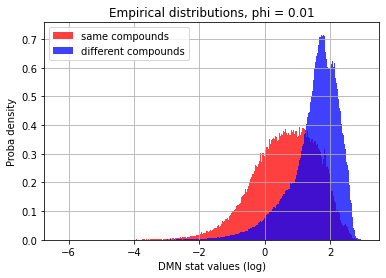

In [7]:
phi = 1e-2

sr1, sr2 = compute_DMN(DMN_same["tables"], phi), compute_DMN(DMN_diff["tables"], phi)
lsr1, lsr2 = np.log(sr1[sr1 > 0]) / np.log(10), np.log(sr2[sr2 > 0]) / np.log(10)
lsr1.hist(bins = 500, color = "r", alpha = 0.75, density = True, label = "same compounds")
lsr2.hist(bins = 500, color = "b", alpha = 0.75, density = True, label = "different compounds")
plt.xlabel("DMN stat values (log)")
plt.ylabel("Proba density")
plt.title("Empirical distributions, phi = " + str(phi))
plt.legend()
plt.show()

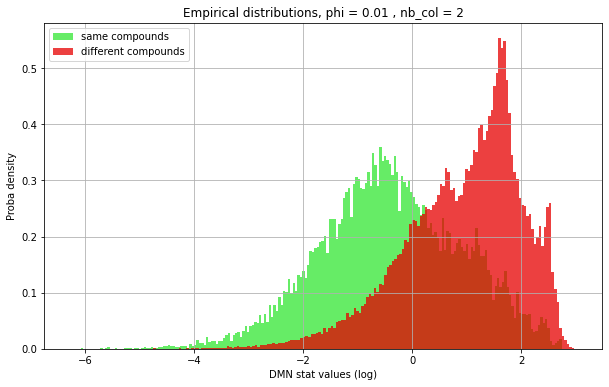

In [8]:
i = 2

stat_same = sr1[DMN_same["nb_col"] == i]
stat_diff = sr2[DMN_diff["nb_col"] == i]

lsr1, lsr2 = np.log(stat_same[stat_same > 0]) / np.log(10), np.log(stat_diff[stat_diff > 0]) / np.log(10)

plt.figure(figsize = (10, 6))
lsr1.hist(bins = 200, color = (0.2, 0.9, 0.2), alpha = 0.75, density = True, label = "same compounds")
lsr2.hist(bins = 200, color = (0.9, 0, 0), alpha = 0.75, density = True, label = "different compounds")
plt.xlabel("DMN stat values (log)")
plt.ylabel("Proba density")
plt.title("Empirical distributions, phi = " + str(phi) + " , nb_col = " + str(i))
plt.legend()
plt.show()


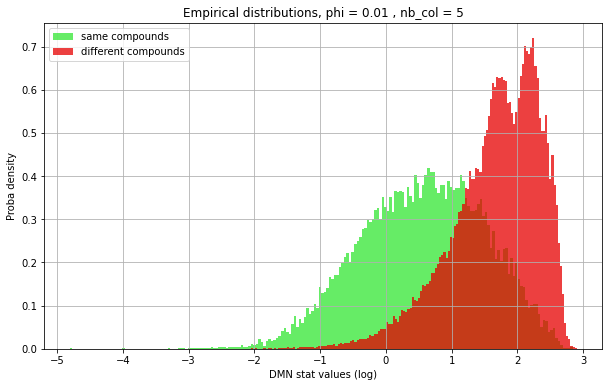

In [9]:
i = 5

stat_same = sr1[DMN_same["nb_col"] == i]
stat_diff = sr2[DMN_diff["nb_col"] == i]

lsr1, lsr2 = np.log(stat_same[stat_same > 0]) / np.log(10), np.log(stat_diff[stat_diff > 0]) / np.log(10)

plt.figure(figsize = (10, 6))
lsr1.hist(bins = 200, color = (0.2, 0.9, 0.2), alpha = 0.75, density = True, label = "same compounds")
lsr2.hist(bins = 200, color = (0.9, 0, 0), alpha = 0.75, density = True, label = "different compounds")
plt.xlabel("DMN stat values (log)")
plt.ylabel("Proba density")
plt.title("Empirical distributions, phi = " + str(phi) + " , nb_col = " + str(i))
plt.legend()
plt.show()


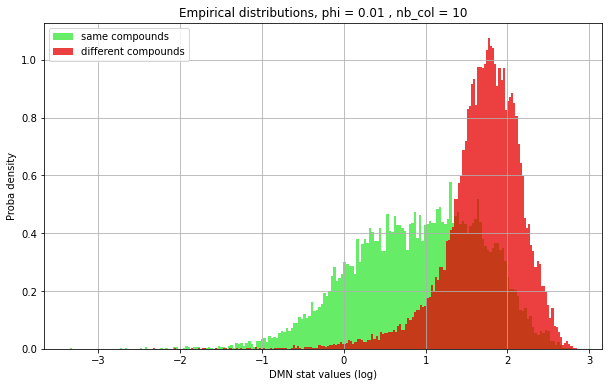

In [10]:
i = 10

stat_same = sr1[DMN_same["nb_col"] == i]
stat_diff = sr2[DMN_diff["nb_col"] == i]

lsr1, lsr2 = np.log(stat_same[stat_same > 0]) / np.log(10), np.log(stat_diff[stat_diff > 0]) / np.log(10)

plt.figure(figsize = (10, 6))
lsr1.hist(bins = 200, color = (0.2, 0.9, 0.2), alpha = 0.75, density = True, label = "same compounds")
lsr2.hist(bins = 200, color = (0.9, 0, 0), alpha = 0.75, density = True, label = "different compounds")
plt.xlabel("DMN stat values (log)")
plt.ylabel("Proba density")
plt.title("Empirical distributions, phi = " + str(phi) + " , nb_col = " + str(i))
plt.legend()
plt.show()


In [11]:
cid_spid["Fallopia_163"]

['R04_01_0947',
 'R04_02_0911',
 'R04_03_0900',
 'R05_01_0882',
 'R05_02_0860',
 'R05_03_0850',
 'R06_01_0913',
 'R06_02_0901',
 'R06_03_0880',
 'R07_01_0926',
 'R07_02_0902',
 'R07_03_0898',
 'R08_01_0911',
 'R08_02_0887',
 'R08_03_0876',
 'R09_01_0896',
 'R09_02_0870',
 'R09_03_0866',
 'R10_01_0821',
 'R10_02_0800',
 'R10_03_0798',
 'R11_01_0826',
 'R11_02_0811',
 'R11_03_0803',
 'R12_01_0832',
 'R12_02_0806',
 'R12_03_0794',
 'R13_01_0881',
 'R13_02_0875',
 'R13_03_0861',
 'R14_01_0845',
 'R14_02_0842',
 'R14_03_0824',
 'R15_01_0818',
 'R15_02_0810',
 'R15_03_0807']

In [12]:
bayesian_si_norm(["Fallopia", "Fallopia"], ["R04_02_0911", "R04_01_0947"])

0.5664982592260751

In [13]:
gp_mz_ppm(get_spectrum("Fallopia", "R04_02_0911"), get_spectrum("Fallopia", "R04_01_0947"))

2.588135350849333

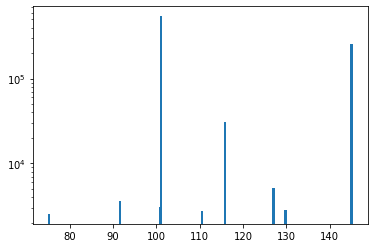

In [14]:
display(get_spectrum("Fallopia", "R04_01_0947"))

In [15]:
gp_mz_ppm(get_spectrum("Fallopia", "R04_01_0947"), get_spectrum("Fallopia", "R04_01_0947"))

4.2153382792618155

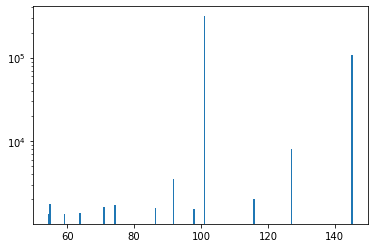

In [16]:
display(get_spectrum("Fallopia", "R04_02_0911"))

In [17]:
DMN_same[DMN_same["nb_col"] == 1]

,tables,nb_col,mq,bsi
0,"[[18900.310546875], [21932.853515625]]",1,0.000,0.162900
1,"[[18900.310546875], [21476.814453125]]",1,0.000,0.168934
2,"[[18900.310546875], [23071.7421875]]",1,0.000,0.232463
3,"[[18900.310546875], [22464.92578125]]",1,0.000,0.176894
4,"[[18900.310546875], [21864.52734375]]",1,0.000,0.223160
...,...,...,...,...
251091,"[[1365596.75], [300278.6875]]",1,0.802,0.181714
251092,"[[1365596.75], [259455.015625]]",1,0.802,0.146572
251093,"[[1365596.75], [342240.6875]]",1,0.802,0.134664
251094,"[[1365596.75], [364315.78125]]",1,0.802,0.138887


In [18]:
def bsi_same(list_id):
    bsi_list = []
    
    for spid in combinations(list_id, 2):
        bsi_list.append(bayesian_si_norm(["Fallopia", "Fallopia"], [spid[0], spid[1]]))
       
    return pd.Series(bsi_list, dtype = float)



def bsi_diff(list_id1, list_id2):
    bsi_list = []

    for spid1 in list_id1:
        for spid2 in list_id2:
            bsi_list.append(bayesian_si_norm(["Fallopia", "Fallopia"], [spid1, spid2]))
            
    return pd.Series(bsi_list, dtype = float)

estimator of $\varphi$ satisfying
$$
\frac{1}{1 + \frac{1}{\hat{\varphi}}} = \frac{1}{2 d} \sum_{j = 1}^d \frac{(x_{1, j} - x_{2, j})^2}{(x_{1, j} + x_{2, j})((1 - x_{1, j}) + (1 - x_{2, j}))} \, ,
$$

where $x_{i, j} = \frac{n_{i, j}}{n_{i, +}}$ .

Empirical values obtained by estimating phi this way and averaging over tables having the same number of columns :


| Columns   | phi       |
|:---------:|:---------:|
| 2         | 0.0184272 |
| 3         | 0.0164307 |
| 4         | 0.0115886 |
| 5         | 0.090360  |
| 6         | 0.0077627 |
| 7         | 0.0070197 |
| 8         | 0.0067279 |
| 9         | 0.0059144 |

In [19]:
def stat_DMN_other(table):
    """Compute an estimated likelihood statistic using the previous functions for a given contingency table. Estimate phi
    from the given contingency table by a moments method (assuming 1 / N phi << 1)."""
    row1 = table[0] / np.sum(table[0])
    row2 = table[1] / np.sum(table[1])
    
    sum_col = row1 + row2
    y = np.sum((row1 - row2) ** 2 / ((sum_col) * (2 - sum_col)))
    phi = 1 / ((2 * len(row1) / y) - 1)
    
    return 2 * (L1_moments(table[0], phi) + L1_moments(table[1], phi) - L0_moments(table, phi))

In [20]:
sr3 = pd.Series([stat_DMN_other(tb) for tb in DMN_same["tables"][DMN_same["nb_col"] == 15]])

In [21]:
sr4 = pd.Series([stat_DMN_other(tb) for tb in DMN_diff["tables"][DMN_diff["nb_col"] == 15]])

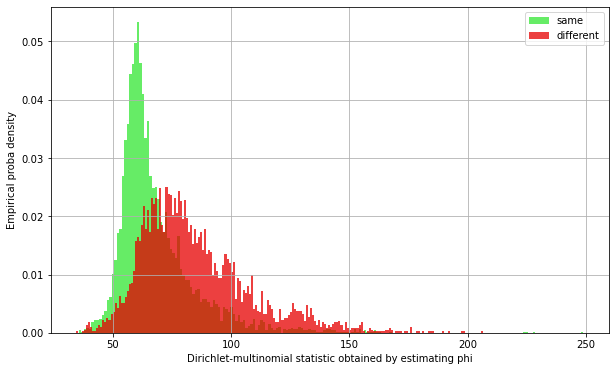

In [22]:
plt.figure(figsize = (10, 6))
sr3.hist(bins = 200, density = True, color = (0.2, 0.9, 0.2), alpha = .75, label = "same")
sr4.hist(bins = 200, density = True, color = (0.9, 0, 0), alpha = .75, label = "different")
plt.xlabel("Dirichlet-multinomial statistic obtained by estimating phi")
plt.ylabel("Empirical proba density")
plt.legend()
plt.show()

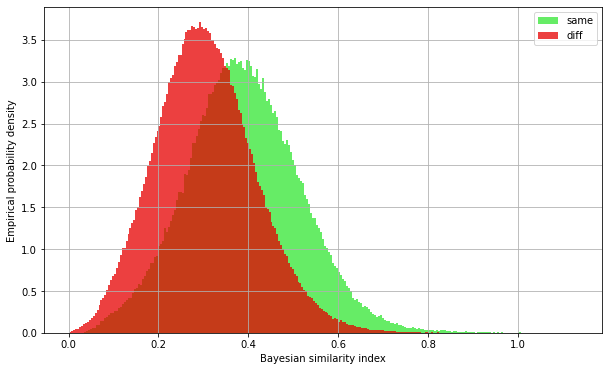

In [23]:
bsi_same = DMN_same["bsi"]
bsi_diff = DMN_diff["bsi"]

plt.figure(figsize = (10, 6))
bsi_same.hist(bins = 250, density = True, color = (0.2, 0.9, 0.2), label = "same", alpha = 0.75)
bsi_diff.hist(bins = 250, density = True, color = (0.9, 0, 0), label = "diff", alpha = 0.75)
plt.xlabel("Bayesian similarity index")
plt.ylabel("Empirical probability density")
plt.legend()
plt.show()

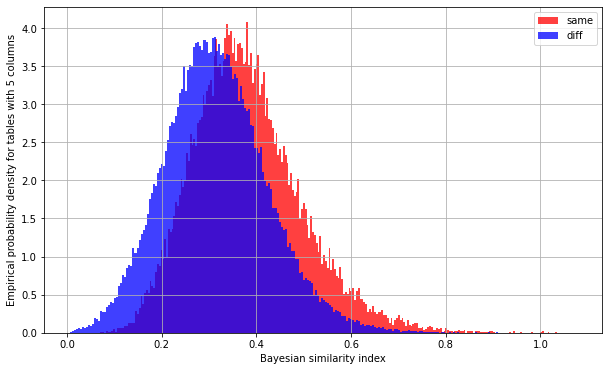

In [24]:
i = 5

bsi_same = DMN_same["bsi"][DMN_same["nb_col"] == i]
bsi_diff = DMN_diff["bsi"][DMN_diff["nb_col"] == i]

plt.figure(figsize = (10, 6))
bsi_same.hist(bins = 250, density = True, color = "red", label = "same", alpha = 0.75)
bsi_diff.hist(bins = 250, density = True, color = "blue", label = "diff", alpha = 0.75)
plt.xlabel("Bayesian similarity index")
plt.ylabel("Empirical probability density for tables with " + str(i) + " columns")
plt.legend()
plt.show()

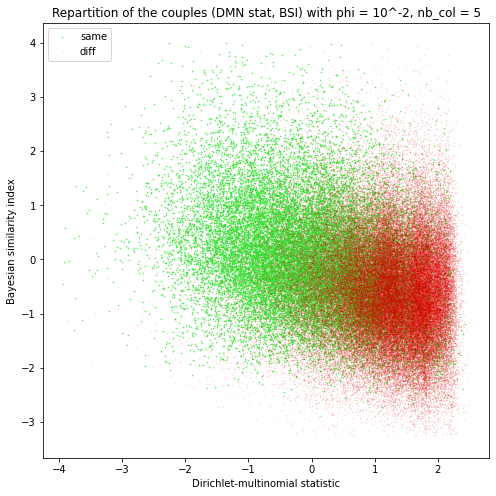

In [25]:
i = 5

stat_same = sr1[DMN_same["nb_col"] == i]
lstat_same = np.log(stat_same[stat_same > 0]) / np.log(10)

stat_diff = sr2[DMN_diff["nb_col"] == i]
lstat_diff = np.log(stat_diff[stat_diff > 0]) / np.log(10)

bsi_same = DMN_same["bsi"][DMN_same["nb_col"] == i][stat_same > 0]
bsi_diff = DMN_diff["bsi"][DMN_diff["nb_col"] == i][stat_diff > 0]

m_x, sigma_x = lstat_same.mean(), lstat_same.std()
m_y, sigma_y = bsi_same.mean(), bsi_same.std()

x_same = (lstat_same - m_x) / sigma_x
y_same = (bsi_same - m_y) / sigma_y

window_same = np.logical_and(np.logical_and(x_same <= 4, x_same >= -4), np.logical_and(y_same >= -4, y_same <= 4))

x_diff = (lstat_diff - m_x) / sigma_x
y_diff = (bsi_diff - m_y) / sigma_y

window_diff = np.logical_and(np.logical_and(x_diff <= 4, x_diff >= - 4), np.logical_and(y_diff >= -4, y_diff <= 4))

plt.figure(figsize = (8, 8))
plt.scatter(x_same[window_same], y_same[window_same], color = (0.2, 0.9, 0.2), s = 1e4 / np.sum(window_same), label = "same", alpha = .75)
plt.scatter(x_diff[window_diff], y_diff[window_diff], color = (0.9, 0, 0), s = 1e4 / np.sum(window_diff), label = "diff", alpha = .2)
plt.xlabel("Dirichlet-multinomial statistic")
plt.ylabel("Bayesian similarity index")
plt.legend()
plt.title("Repartition of the couples (DMN stat, BSI) with phi = 10^-2, nb_col = " + str(i))
plt.show()

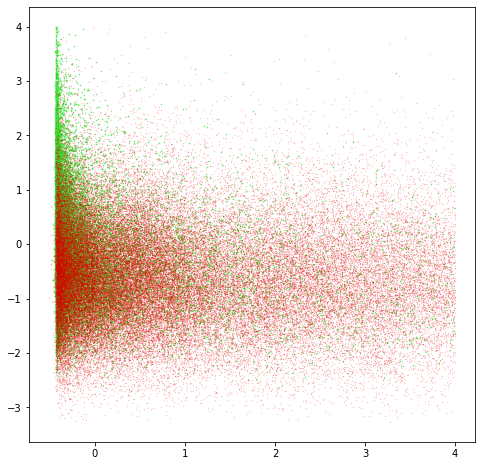

In [26]:
i = 5

stat_same = sr1[DMN_same["nb_col"] == i]

stat_diff = sr2[DMN_diff["nb_col"] == i]

bsi_same = DMN_same["bsi"][DMN_same["nb_col"] == i]
bsi_diff = DMN_diff["bsi"][DMN_diff["nb_col"] == i]

m_x, sigma_x = stat_same.mean(), stat_same.std()
m_y, sigma_y = bsi_same.mean(), bsi_same.std()

x_same = np.array((stat_same - m_x) / sigma_x)
y_same = np.array((bsi_same - m_y) / sigma_y)

window_same = np.logical_and(np.logical_and(x_same < 4, x_same > -4), np.logical_and(y_same > -4, y_same < 4))

x_diff = np.array((stat_diff - m_x) / sigma_x)
y_diff = np.array((bsi_diff - m_y) / sigma_y)

window_diff = np.logical_and(np.logical_and(x_diff < 4, x_diff > - 4), np.logical_and(y_diff > -4, y_diff < 4))

plt.figure(figsize = (8, 8))
plt.scatter(x_same[window_same], y_same[window_same], color = (0.2, 0.9, 0.2), s = 0.3, label = "same", alpha = .75)
plt.scatter(x_diff[window_diff], y_diff[window_diff], color = (0.9, 0, 0), s = 0.05, label = "diff", alpha = .4)

plt.show()

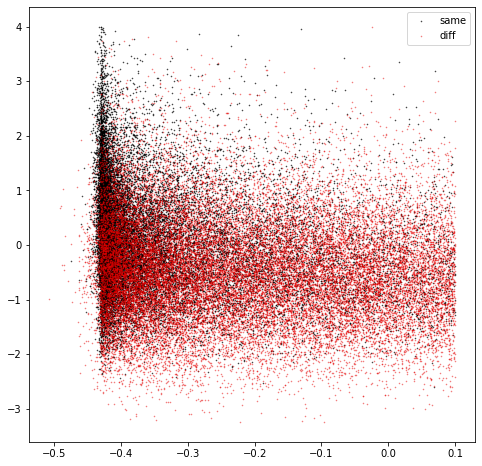

In [27]:
i = 5

stat_same = sr1[DMN_same["nb_col"] == i]

stat_diff = sr2[DMN_diff["nb_col"] == i]

bsi_same = DMN_same["bsi"][DMN_same["nb_col"] == i]
bsi_diff = DMN_diff["bsi"][DMN_diff["nb_col"] == i]

m_x, sigma_x = stat_same.mean(), stat_same.std()
m_y, sigma_y = bsi_same.mean(), bsi_same.std()

x_same = np.array((stat_same - m_x) / sigma_x)
y_same = np.array((bsi_same - m_y) / sigma_y)

window_same = np.logical_and(x_same < .1, np.logical_and(y_same > -4, y_same < 4))

x_diff = np.array((stat_diff - m_x) / sigma_x)
y_diff = np.array((bsi_diff - m_y) / sigma_y)

window_diff = np.logical_and(x_diff < .1, np.logical_and(y_diff > -4, y_diff < 4))

plt.figure(figsize = (8, 8))
plt.scatter(x_same[window_same], y_same[window_same], color = "k", s = 0.3, label = "same", alpha = .75)
plt.scatter(x_diff[window_diff], y_diff[window_diff], color = (0.9, 0, 0), s = 0.3, label = "diff", alpha = .5)
plt.legend()
plt.show()

In [28]:
lst_couple_cid

[('Fallopia_009', 'Fallopia_004'),
 ('Fallopia_360', 'Fallopia_494'),
 ('Fallopia_670', 'Fallopia_910'),
 ('Fallopia_133', 'Fallopia_092'),
 ('Fallopia_084', 'Fallopia_480'),
 ('Fallopia_083', 'Fallopia_001'),
 ('Fallopia_095', 'Fallopia_485'),
 ('Fallopia_289', 'Fallopia_288'),
 ('Fallopia_065', 'Fallopia_059'),
 ('Fallopia_416', 'Fallopia_053'),
 ('Fallopia_416', 'Fallopia_417'),
 ('Fallopia_416', 'Fallopia_055'),
 ('Fallopia_053', 'Fallopia_417'),
 ('Fallopia_053', 'Fallopia_055'),
 ('Fallopia_417', 'Fallopia_055'),
 ('Fallopia_197', 'Fallopia_005'),
 ('Fallopia_197', 'Fallopia_010'),
 ('Fallopia_197', 'Fallopia_219'),
 ('Fallopia_005', 'Fallopia_010'),
 ('Fallopia_005', 'Fallopia_219'),
 ('Fallopia_010', 'Fallopia_219'),
 ('Fallopia_060', 'Fallopia_603'),
 ('Fallopia_350', 'Fallopia_658'),
 ('Fallopia_721', 'Fallopia_233'),
 ('Fallopia_721', 'Fallopia_234'),
 ('Fallopia_233', 'Fallopia_234'),
 ('Fallopia_011', 'Fallopia_346'),
 ('Fallopia_280', 'Fallopia_491'),
 ('Fallopia_280', 'F

In [29]:
len(lst_couple_cid)

985

In [30]:
len(cid_similar)

593

In [34]:
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["figure.dpi"] = 200

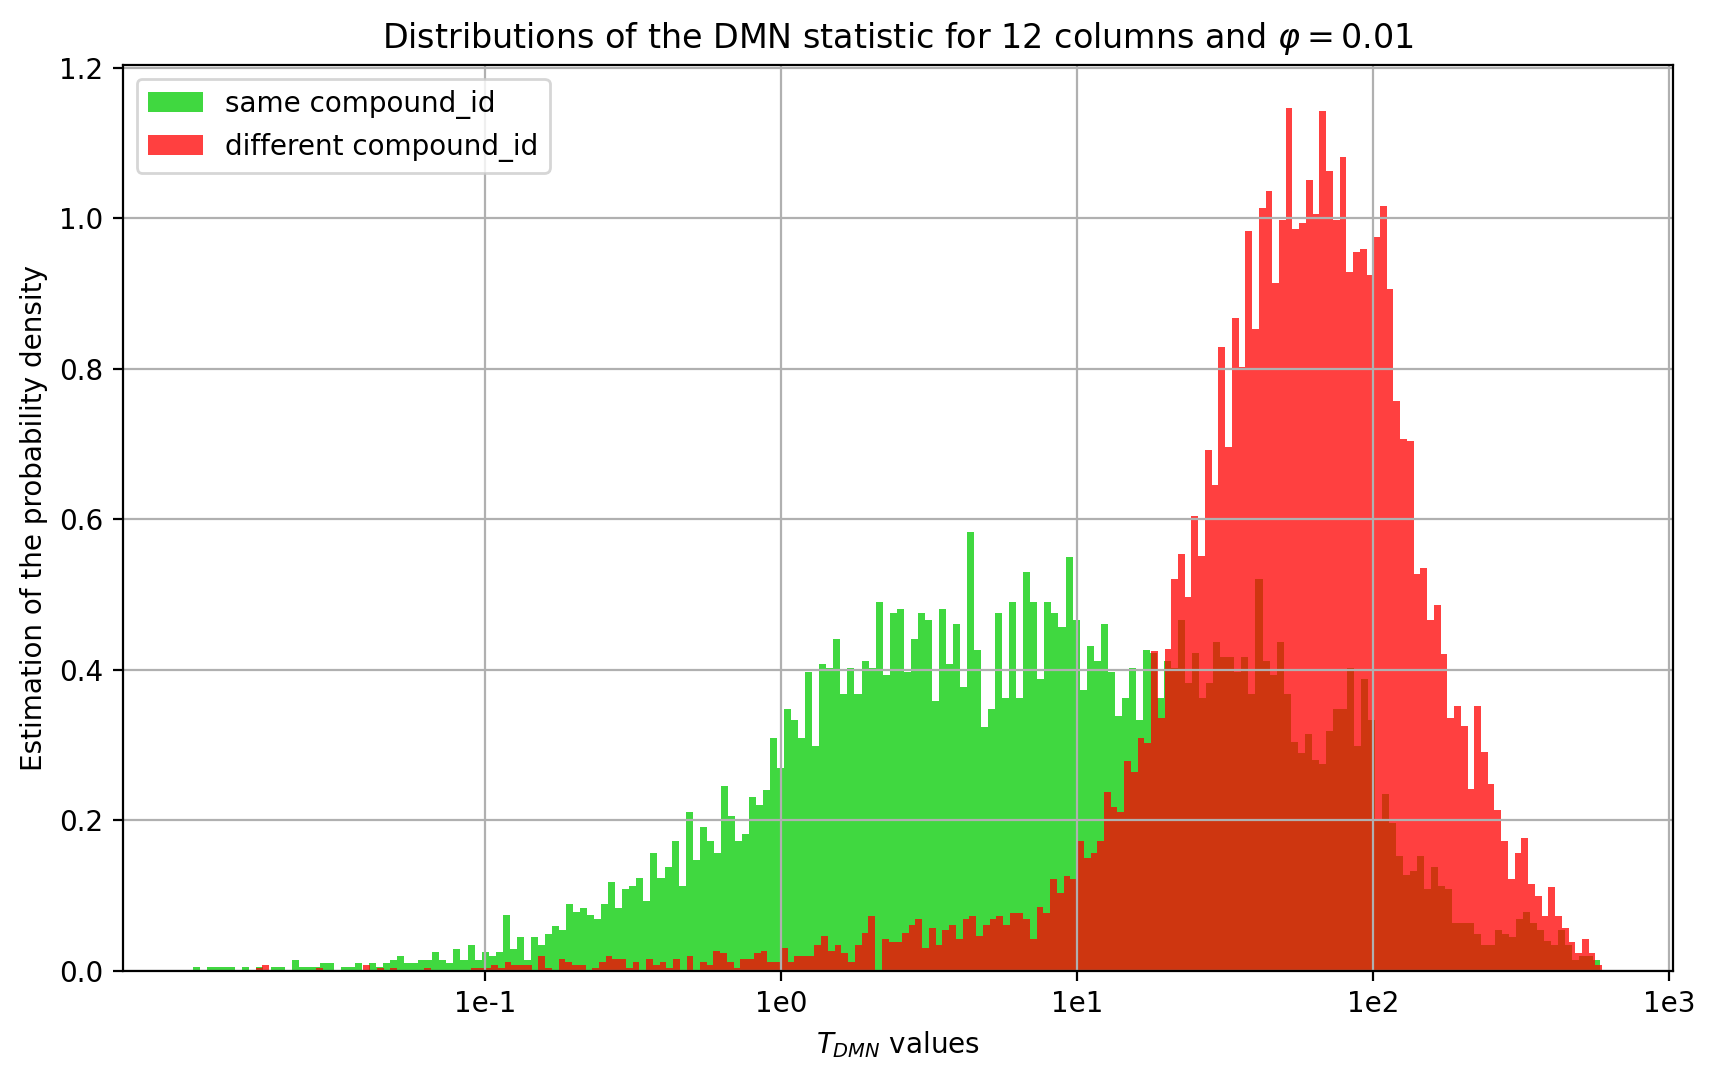

In [40]:
i = 12

stat_same = sr1[DMN_same["nb_col"] == i]
stat_diff = sr2[DMN_diff["nb_col"] == i]

lsr1 = np.log(stat_same[stat_same > 0.01]) / np.log(10)
lsr2 = np.log(stat_diff[stat_diff > 0.01]) / np.log(10)

plt.figure(figsize = (10, 6))
lsr1.hist(bins = 200, color = (0, 0.8, 0), alpha = 0.75, density = True, label = "same compound_id")
lsr2.hist(bins = 200, color = (1, 0, 0), alpha = 0.75, density = True, label = "different compound_id")
plt.xlabel(r"$T_{DMN}$ values")

xmin = -2
xmax = 3
ticks = np.array((range(int(xmin) + 1, int(xmax) + 1)))
plt.xticks(ticks)

ax = plt.gca()
ax.set_xticklabels(["1e" + str(exp) for exp in ticks])
ax.xaxis.set_minor_locator(tk.NullLocator())


plt.ylabel("Estimation of the probability density")
plt.title(r"Distributions of the DMN statistic for 12 columns and $\varphi = 0.01$")
plt.legend()
plt.show()

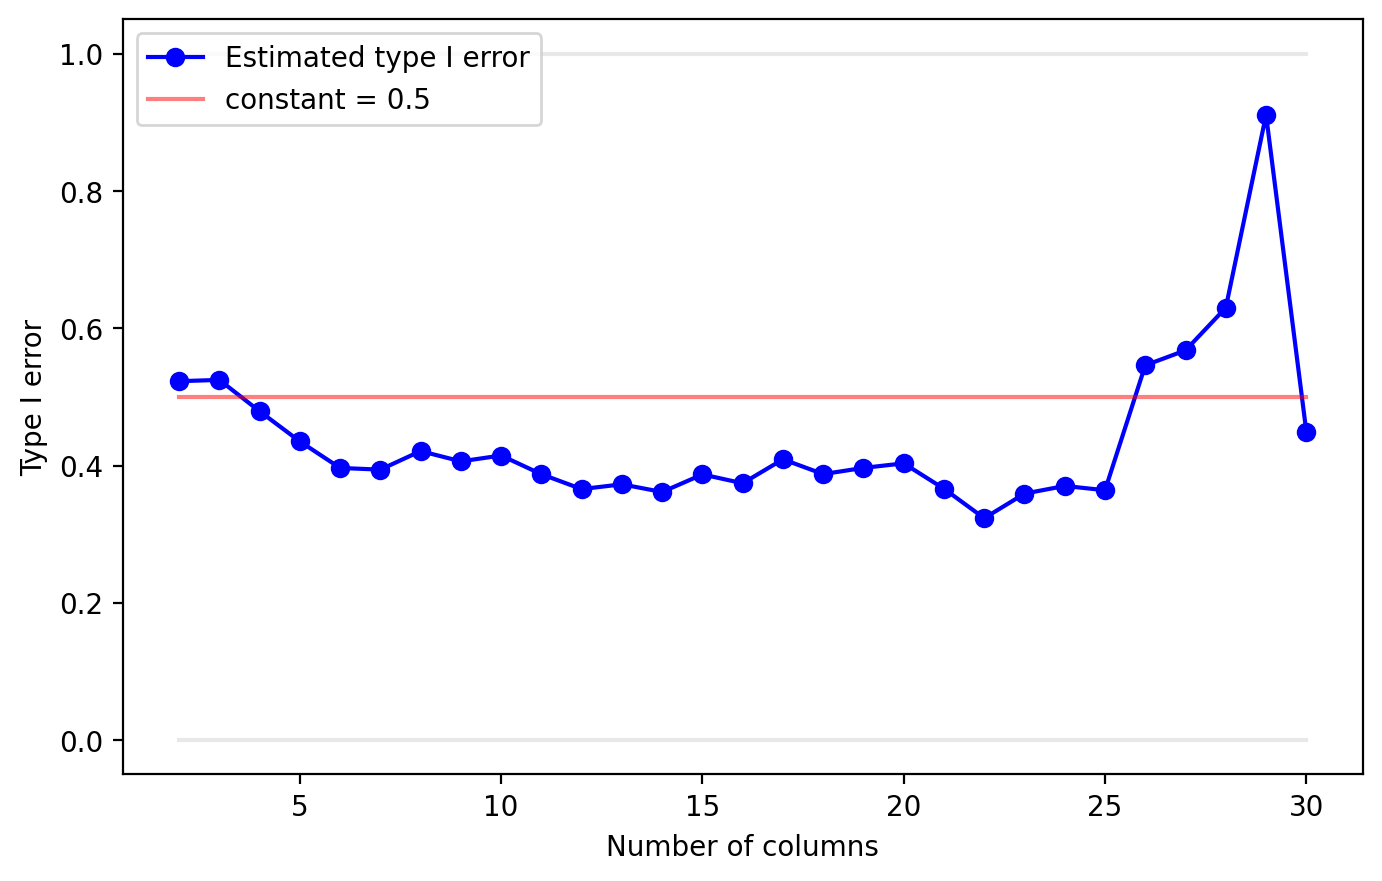

In [41]:


nb_cols = np.arange(2, 31)
beta = 0.1
alphas = []

for i in nb_cols:
    
    stat_same = sr1[DMN_same["nb_col"] == i]
    stat_diff = sr2[DMN_diff["nb_col"] == i]
    
    th = stat_diff.quantile(beta)
    alpha = sum(stat_same > th) / len(stat_same)
    alphas.append(alpha)
    
plt.plot(nb_cols, alphas, marker = "o", color = "blue", label = "Estimated type I error")
plt.plot(nb_cols, len(nb_cols) * [0], color = "lightgrey", alpha = 0.5)
plt.plot(nb_cols, len(nb_cols) * [1], color = "lightgrey", alpha = 0.5)
plt.plot(nb_cols, len(nb_cols) * [0.5], color = "red", alpha = 0.5, label = "constant = 0.5")

plt.xlabel("Number of columns")
plt.ylabel("Type I error")

plt.legend()

In [42]:
phi = 1e-5

sr1, sr2 = compute_DMN(DMN_same["tables"], phi), compute_DMN(DMN_diff["tables"], phi)

  0%|          | 0/253659 [00:00<?, ?it/s]

  0%|          | 0/703206 [00:00<?, ?it/s]

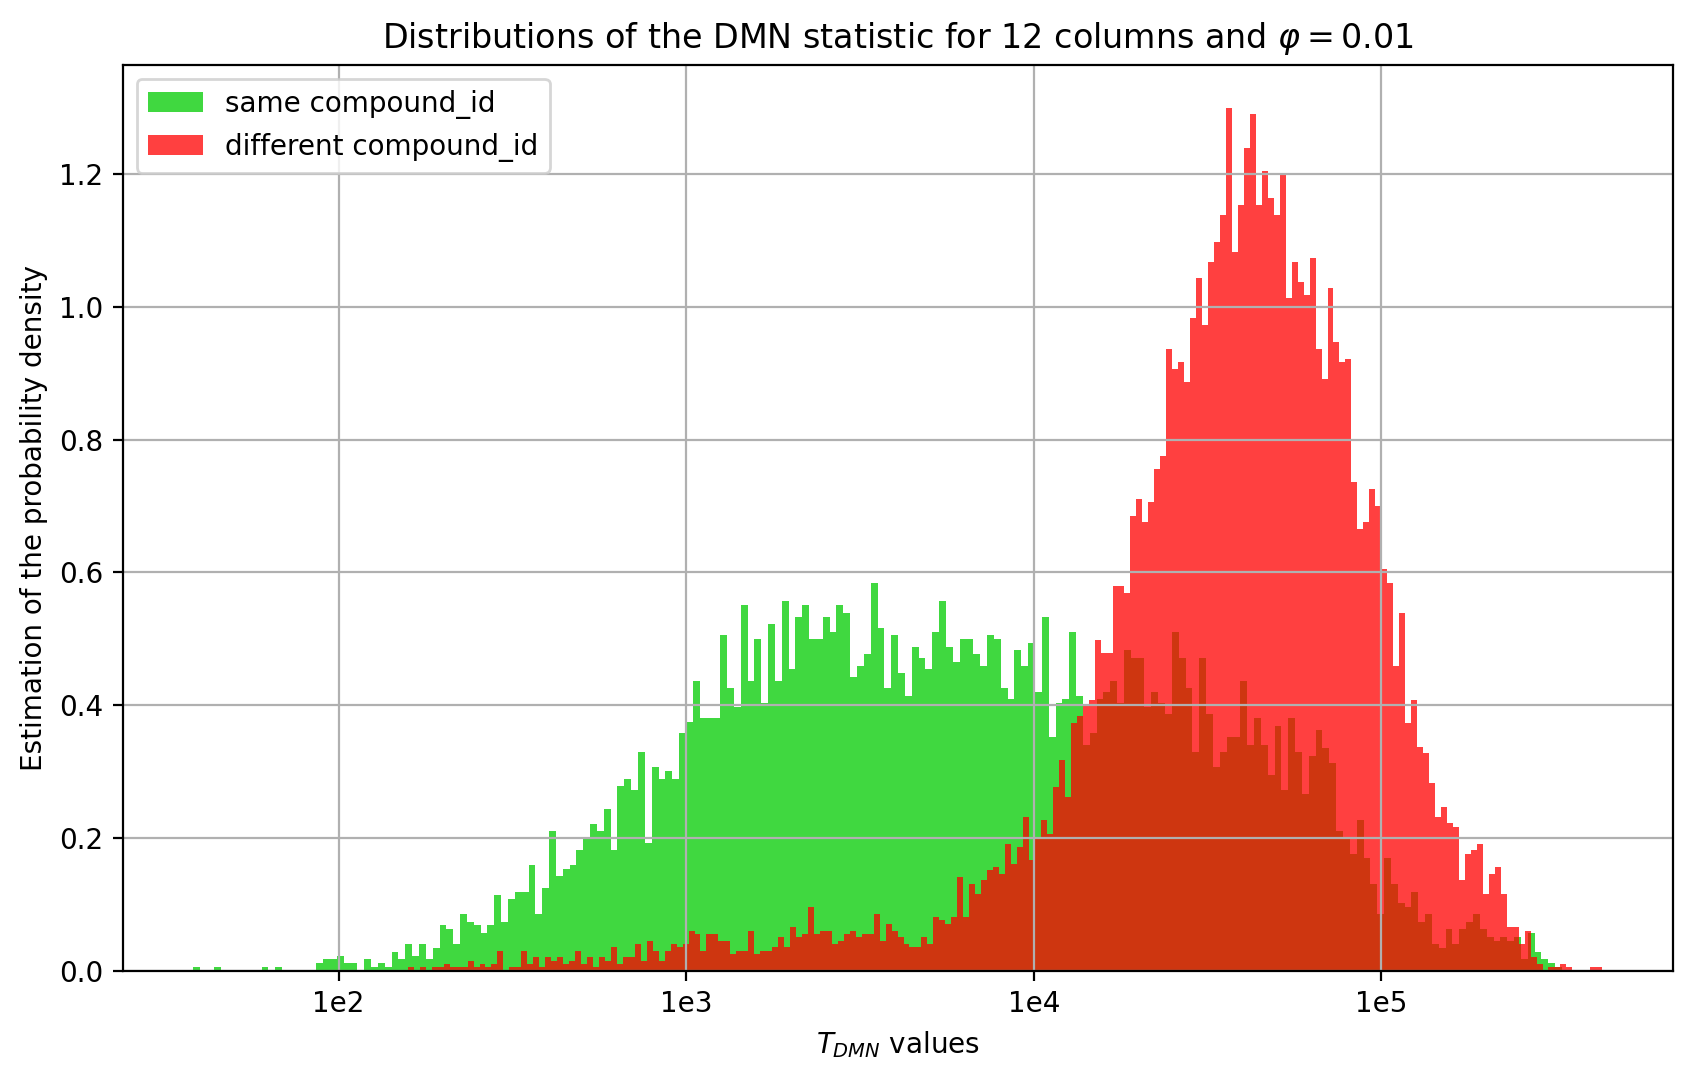

In [45]:
i = 12

stat_same = sr1[DMN_same["nb_col"] == i]
stat_diff = sr2[DMN_diff["nb_col"] == i]

lsr1 = np.log(stat_same[stat_same > 0.01]) / np.log(10)
lsr2 = np.log(stat_diff[stat_diff > 0.01]) / np.log(10)

plt.figure(figsize = (10, 6))
lsr1.hist(bins = 200, color = (0, 0.8, 0), alpha = 0.75, density = True, label = "same compound_id")
lsr2.hist(bins = 200, color = (1, 0, 0), alpha = 0.75, density = True, label = "different compound_id")
plt.xlabel(r"$T_{DMN}$ values")

xmin = 1
xmax = 5
ticks = np.array((range(int(xmin) + 1, int(xmax) + 1)))
plt.xticks(ticks)

ax = plt.gca()
ax.set_xticklabels(["1e" + str(exp) for exp in ticks])
ax.xaxis.set_minor_locator(tk.NullLocator())


plt.ylabel("Estimation of the probability density")
plt.title(r"Distributions of the DMN statistic for 12 columns and $\varphi = 0.01$")
plt.legend()
plt.show()

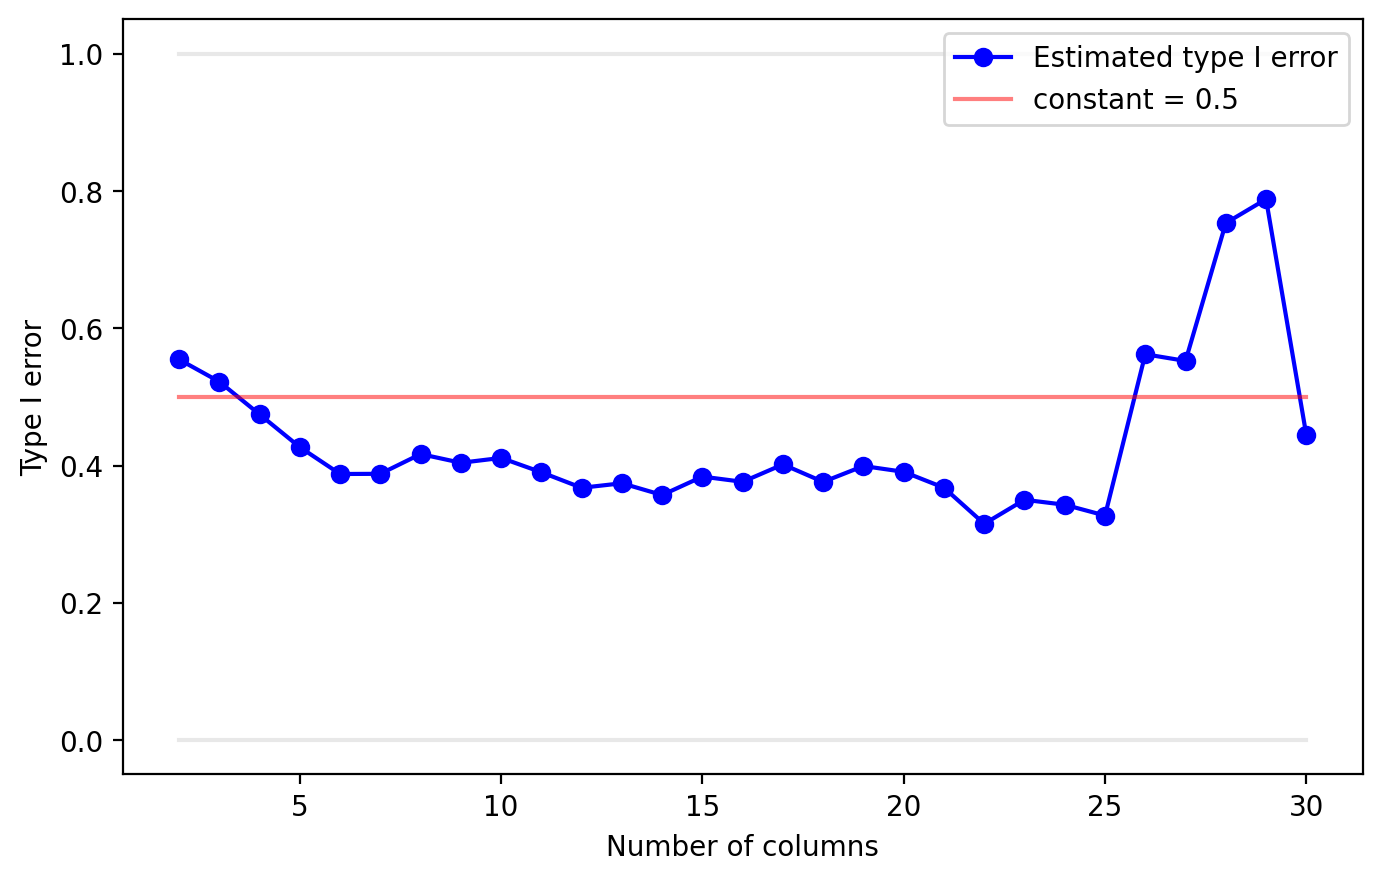

In [44]:
nb_cols = np.arange(2, 31)
beta = 0.1
alphas = []

for i in nb_cols:
    
    stat_same = sr1[DMN_same["nb_col"] == i]
    stat_diff = sr2[DMN_diff["nb_col"] == i]
    
    th = stat_diff.quantile(beta)
    alpha = sum(stat_same > th) / len(stat_same)
    alphas.append(alpha)
    
plt.plot(nb_cols, alphas, marker = "o", color = "blue", label = "Estimated type I error")
plt.plot(nb_cols, len(nb_cols) * [0], color = "lightgrey", alpha = 0.5)
plt.plot(nb_cols, len(nb_cols) * [1], color = "lightgrey", alpha = 0.5)
plt.plot(nb_cols, len(nb_cols) * [0.5], color = "red", alpha = 0.5, label = "constant = 0.5")

plt.xlabel("Number of columns")
plt.ylabel("Type I error")

plt.legend()

In [48]:
phi = pow(10, -3.5)

sr1, sr2 = compute_DMN(DMN_same["tables"], phi), compute_DMN(DMN_diff["tables"], phi)

  0%|          | 0/253659 [00:00<?, ?it/s]

  0%|          | 0/703206 [00:00<?, ?it/s]

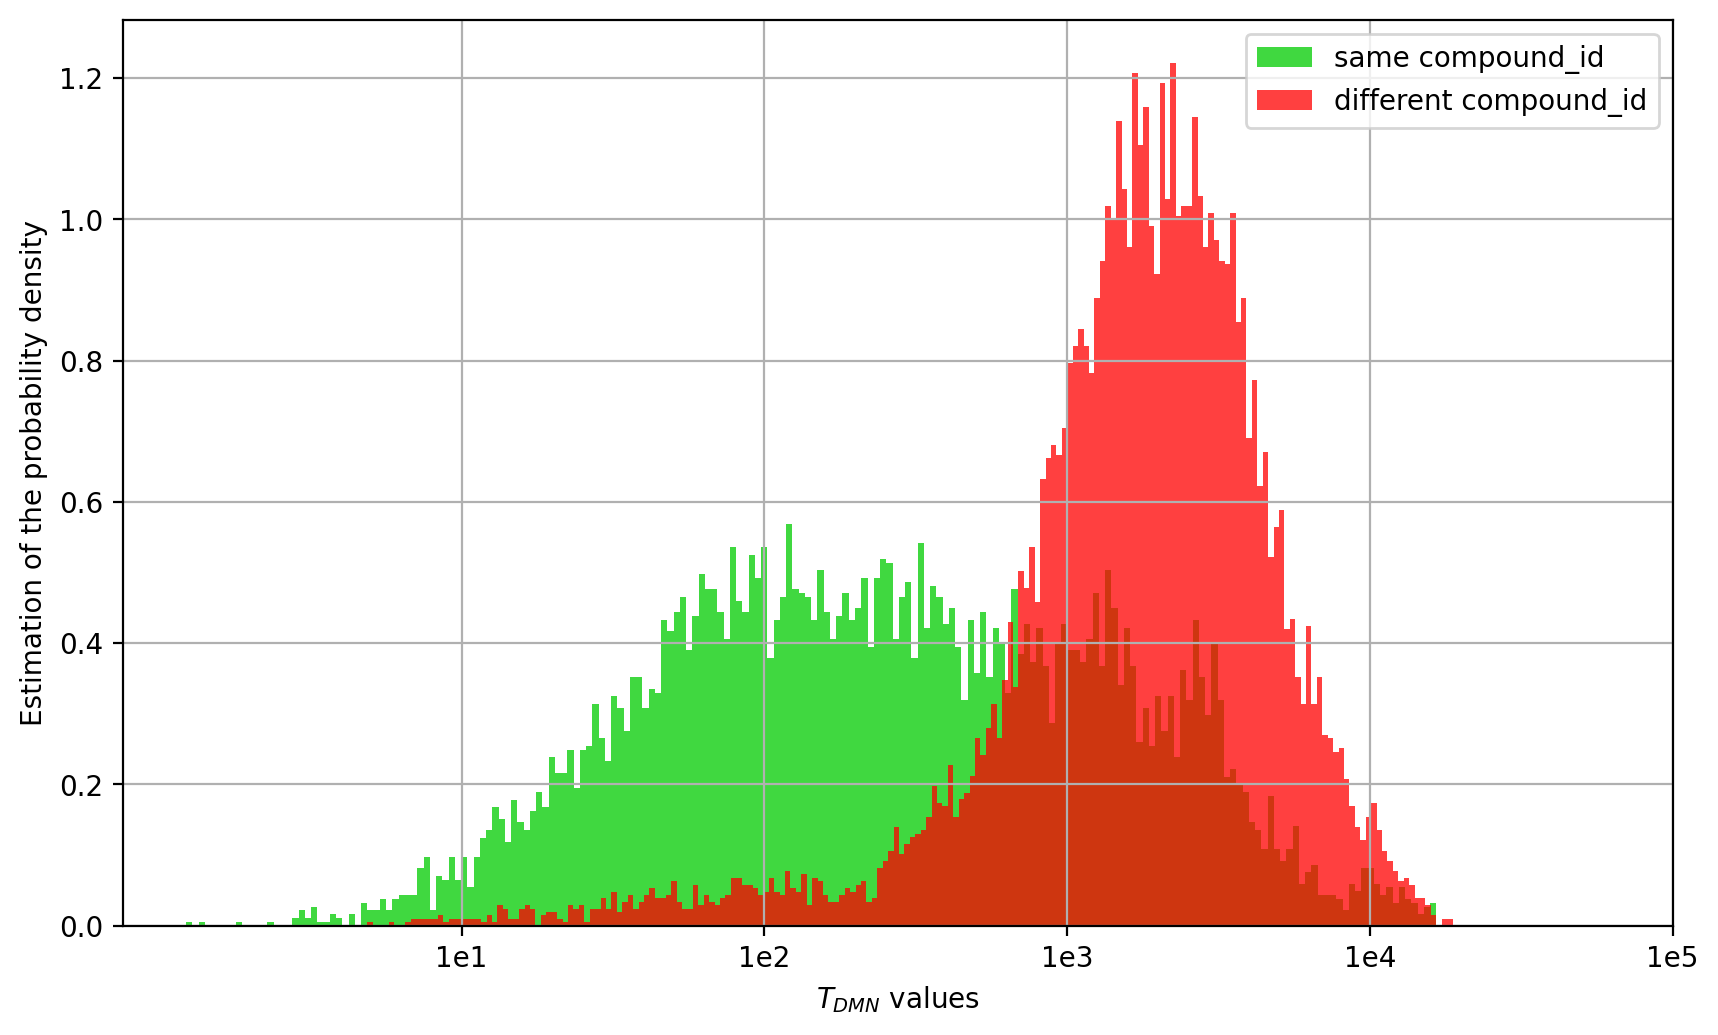

In [61]:
i = 12

stat_same = sr1[DMN_same["nb_col"] == i]
stat_diff = sr2[DMN_diff["nb_col"] == i]

lsr1 = np.log(stat_same[stat_same > 0.01]) / np.log(10)
lsr2 = np.log(stat_diff[stat_diff > 0.01]) / np.log(10)

plt.figure(figsize = (10, 6))
lsr1.hist(bins = 200, color = (0, 0.8, 0), alpha = 0.75, density = True, label = "same compound_id")
lsr2.hist(bins = 200, color = (1, 0, 0), alpha = 0.75, density = True, label = "different compound_id")
plt.xlabel(r"$T_{DMN}$ values")

xmin = 0
xmax = 5
ticks = np.array((range(int(xmin) + 1, int(xmax) + 1)))
plt.xticks(ticks)

ax = plt.gca()
ax.set_xticklabels(["1e" + str(exp) for exp in ticks])
ax.xaxis.set_minor_locator(tk.NullLocator())


plt.ylabel("Estimation of the probability density")
plt.legend()

plt.show()

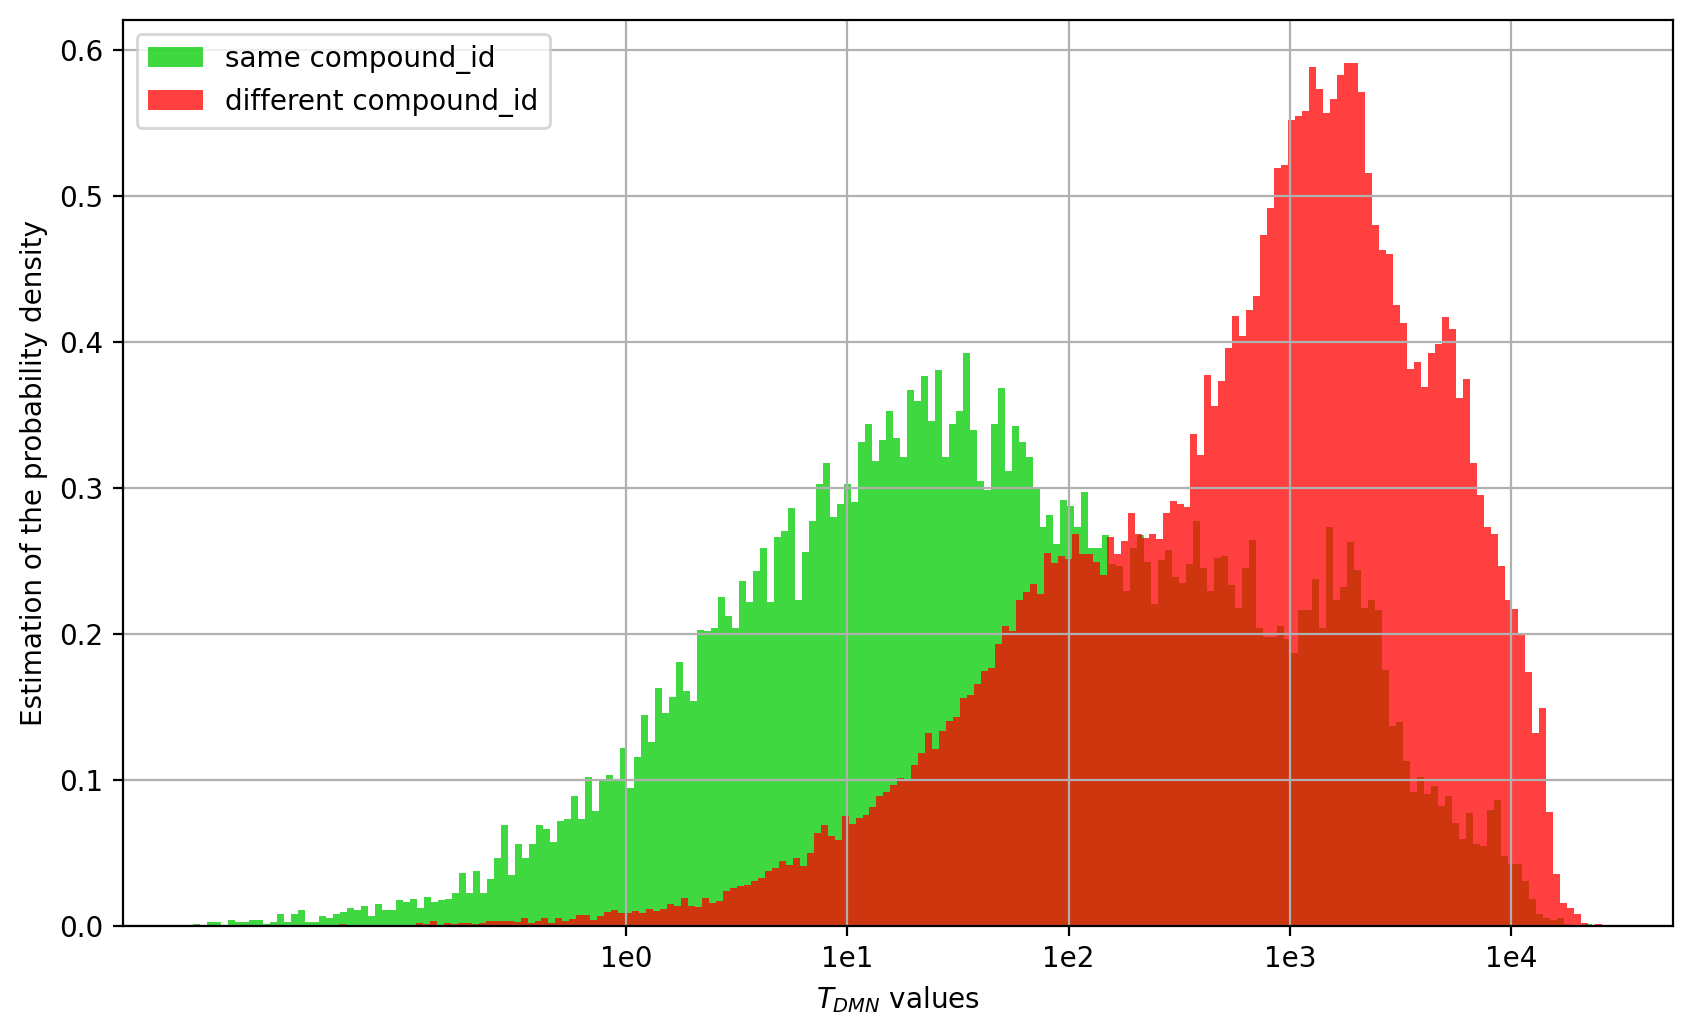

In [62]:
i = 3

stat_same = sr1[DMN_same["nb_col"] == i]
stat_diff = sr2[DMN_diff["nb_col"] == i]

lsr1 = np.log(stat_same[stat_same > 0.01]) / np.log(10)
lsr2 = np.log(stat_diff[stat_diff > 0.01]) / np.log(10)

plt.figure(figsize = (10, 6))
lsr1.hist(bins = 200, color = (0, 0.8, 0), alpha = 0.75, density = True, label = "same compound_id")
lsr2.hist(bins = 200, color = (1, 0, 0), alpha = 0.75, density = True, label = "different compound_id")
plt.xlabel(r"$T_{DMN}$ values")

xmin = -1
xmax = 4
ticks = np.array((range(int(xmin) + 1, int(xmax) + 1)))
plt.xticks(ticks)

ax = plt.gca()
ax.set_xticklabels(["1e" + str(exp) for exp in ticks])
ax.xaxis.set_minor_locator(tk.NullLocator())


plt.ylabel("Estimation of the probability density")
plt.legend()

plt.show()

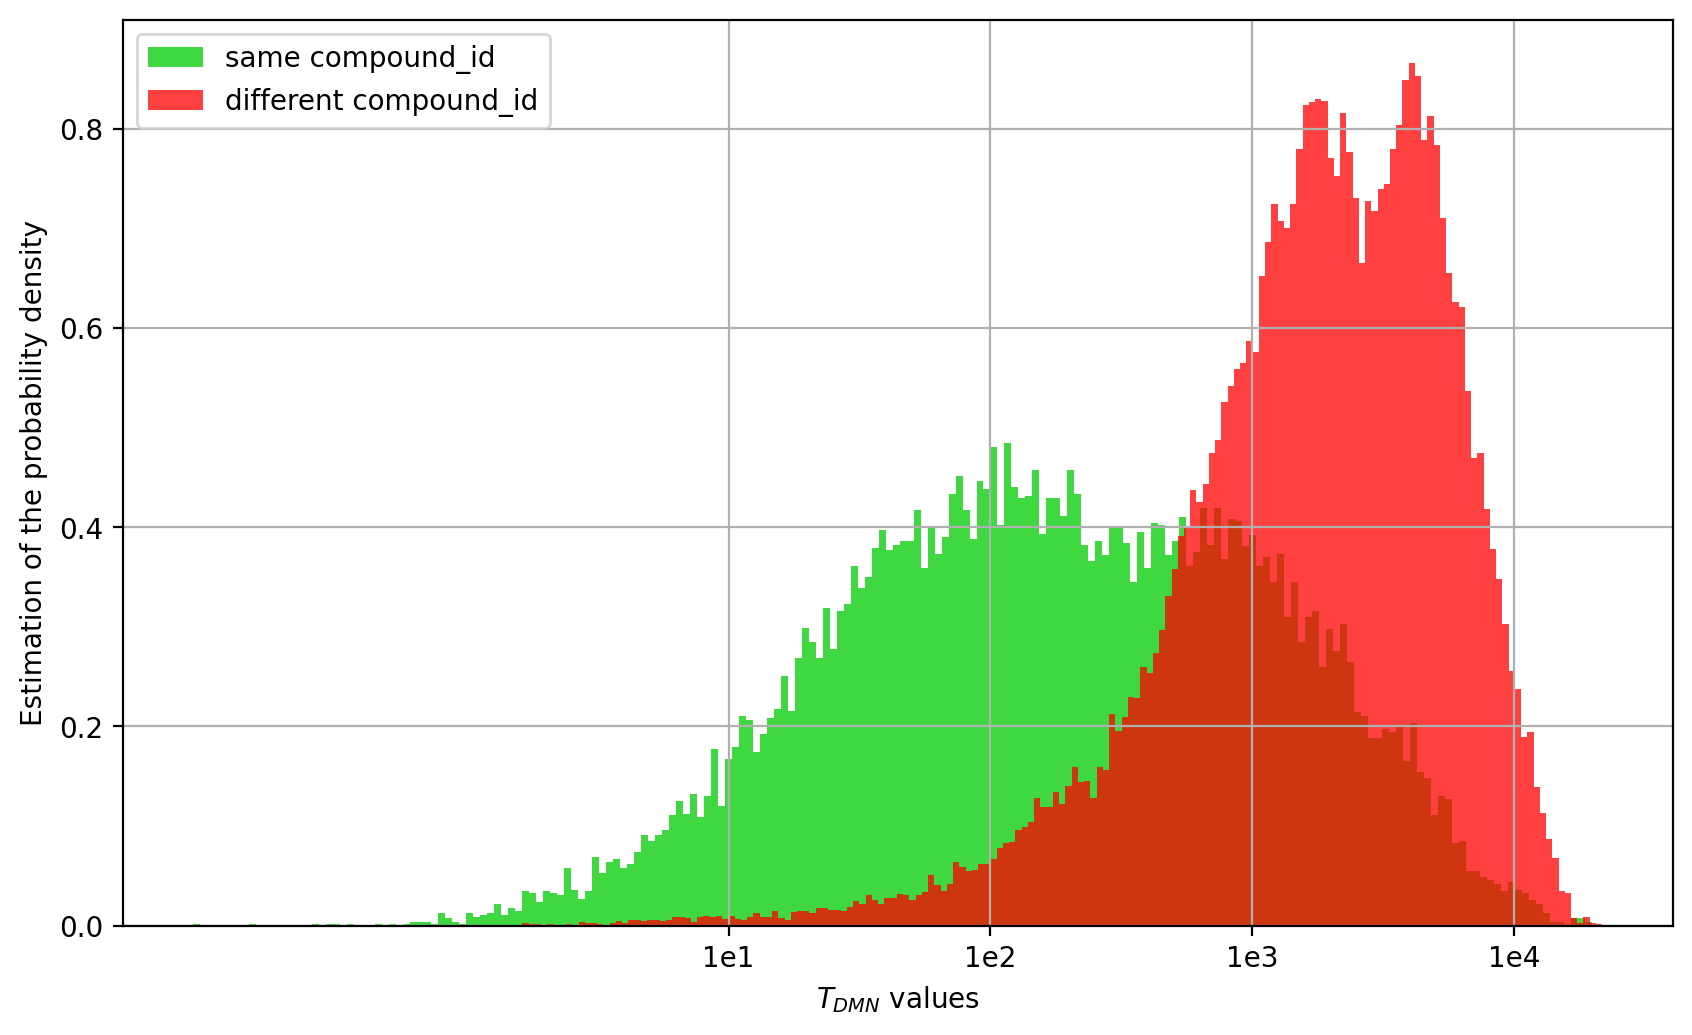

In [63]:
i = 7

stat_same = sr1[DMN_same["nb_col"] == i]
stat_diff = sr2[DMN_diff["nb_col"] == i]

lsr1 = np.log(stat_same[stat_same > 0.01]) / np.log(10)
lsr2 = np.log(stat_diff[stat_diff > 0.01]) / np.log(10)

plt.figure(figsize = (10, 6))
lsr1.hist(bins = 200, color = (0, 0.8, 0), alpha = 0.75, density = True, label = "same compound_id")
lsr2.hist(bins = 200, color = (1, 0, 0), alpha = 0.75, density = True, label = "different compound_id")
plt.xlabel(r"$T_{DMN}$ values")

xmin = 0
xmax = 4
ticks = np.array((range(int(xmin) + 1, int(xmax) + 1)))
plt.xticks(ticks)

ax = plt.gca()
ax.set_xticklabels(["1e" + str(exp) for exp in ticks])
ax.xaxis.set_minor_locator(tk.NullLocator())


plt.ylabel("Estimation of the probability density")
plt.legend()

plt.show()

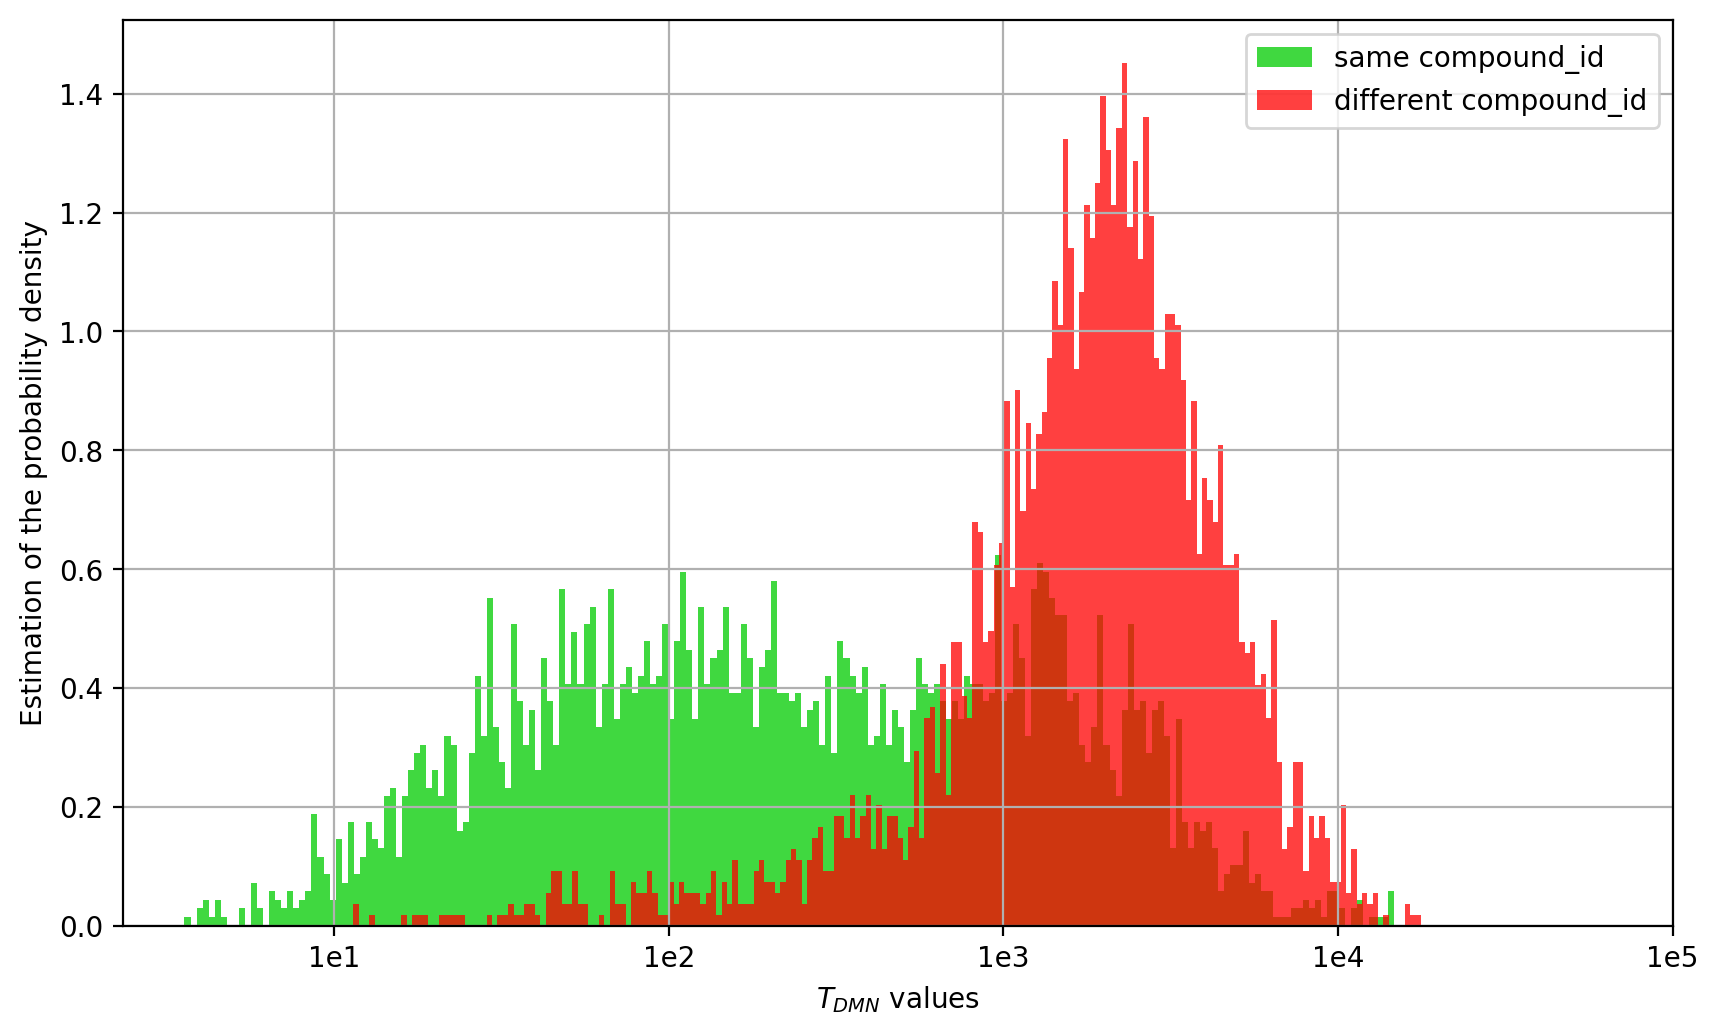

In [64]:
i = 16

stat_same = sr1[DMN_same["nb_col"] == i]
stat_diff = sr2[DMN_diff["nb_col"] == i]

lsr1 = np.log(stat_same[stat_same > 0.01]) / np.log(10)
lsr2 = np.log(stat_diff[stat_diff > 0.01]) / np.log(10)

plt.figure(figsize = (10, 6))
lsr1.hist(bins = 200, color = (0, 0.8, 0), alpha = 0.75, density = True, label = "same compound_id")
lsr2.hist(bins = 200, color = (1, 0, 0), alpha = 0.75, density = True, label = "different compound_id")
plt.xlabel(r"$T_{DMN}$ values")

xmin = 0
xmax = 5
ticks = np.array((range(int(xmin) + 1, int(xmax) + 1)))
plt.xticks(ticks)

ax = plt.gca()
ax.set_xticklabels(["1e" + str(exp) for exp in ticks])
ax.xaxis.set_minor_locator(tk.NullLocator())


plt.ylabel("Estimation of the probability density")
plt.legend()

plt.show()

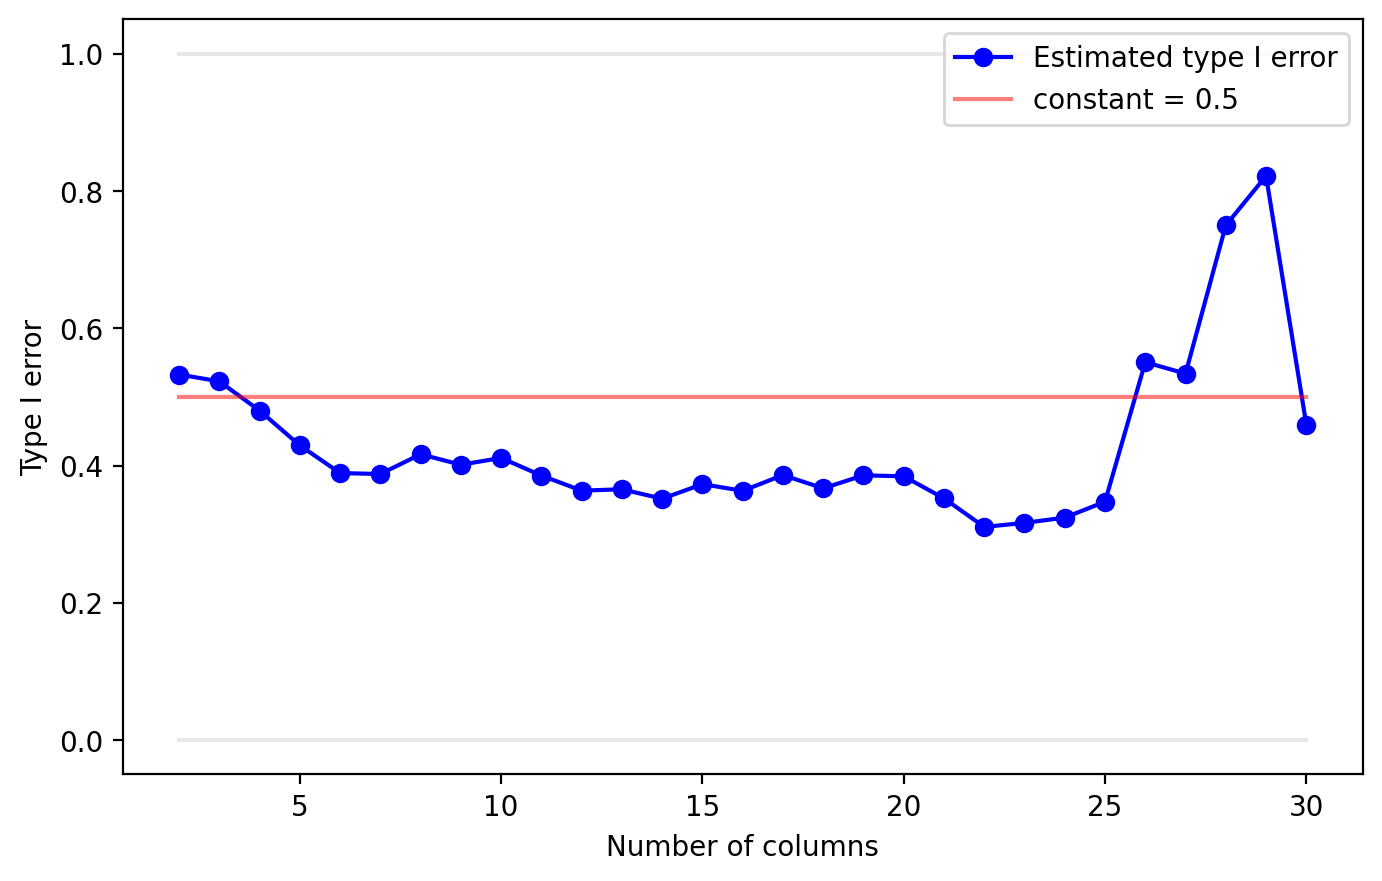

In [50]:
nb_cols = np.arange(2, 31)
beta = 0.1
alphas = []

for i in nb_cols:
    
    stat_same = sr1[DMN_same["nb_col"] == i]
    stat_diff = sr2[DMN_diff["nb_col"] == i]
    
    th = stat_diff.quantile(beta)
    alpha = sum(stat_same > th) / len(stat_same)
    alphas.append(alpha)
    
plt.plot(nb_cols, alphas, marker = "o", color = "blue", label = "Estimated type I error")
plt.plot(nb_cols, len(nb_cols) * [0], color = "lightgrey", alpha = 0.5)
plt.plot(nb_cols, len(nb_cols) * [1], color = "lightgrey", alpha = 0.5)
plt.plot(nb_cols, len(nb_cols) * [0.5], color = "red", alpha = 0.5, label = "constant = 0.5")

plt.xlabel("Number of columns")
plt.ylabel("Type I error")

plt.legend()